In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from t_sne import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

In [3]:
X = pd.read_csv("data/mnist_train.csv")

def select_digits(x):
    digits = [0, 1, 2]
    num_samples = 80
    if x.name not in digits:
        return None
    return x.iloc[:num_samples, :]

X_selected = X.groupby(by=["label"]).apply(select_digits)
X_selected = X_selected.reset_index(drop=True)

X_numpy = X_selected.iloc[:, 1:].to_numpy()
y_true = X_selected.iloc[:, 0]

In [29]:
pca = PCA()

pca.fit_transform(X_numpy)

cum_var_explained = np.cumsum(pca.explained_variance_ratio_)

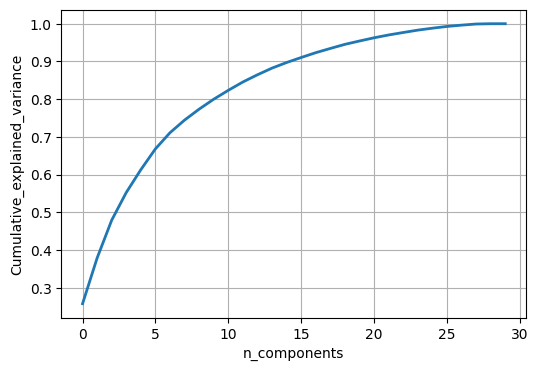

In [30]:
# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [31]:
n_components = np.min(np.where(cum_var_explained > 0.9)[0])
n_components

15

In [32]:
V = pca.components_[:n_components].T

X_transform = X_numpy @ V

print(X_transform.shape)

(30, 15)


In [19]:
num_iters=500
perplexity=20
lr=5.

tsne = TSNE(num_iters, perplexity, lr)

Y = tsne.fit(X_numpy)

Finding sigmas


100%|██████████| 500/500 [00:01<00:00, 348.43it/s]


In [20]:
kmeans = MiniBatchKMeans(n_clusters=3,
                        random_state=0,
                        batch_size=20,
                        max_iter=10,
                        n_init="auto").fit(Y)
y_hat = kmeans.labels_

In [21]:
print(y_true[:20])
print(y_hat[:20])

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
Name: label, dtype: int64
[1 0 1 0 2 1 0 2 1 0 0 0 0 1 0 0 0 2 0 0]


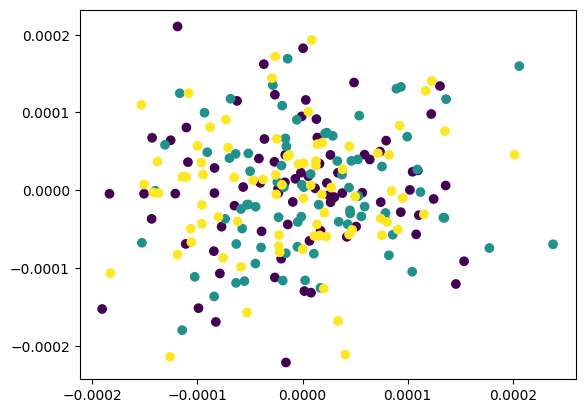

In [22]:
plt.scatter(Y[:, 0], Y[:, 1], c=y_true)
plt.show()

In [ ]:
with open("data/reduced.npy", "wb") as f:
    np.save(f, Y)

In [18]:
-1e-8 * np.log2(1e-8)

2.65754247590989e-07